In [1]:
import torch
import numpy as np
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# from src.models.pointNetVae import PointNetVAE
import matplotlib.pyplot as plt
from src.models.PointNetVae_chamfer_split import PointNetVAE
from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
norm_train = '../data/processed/point/Pfam_Point_norm_proc/Pfam_data_train_norm.pt'
norm_val = '../data/processed/point/Pfam_Point_norm_proc/Pfam_data_val_norm.pt'
labels_train = '../data/processed/point/Pfam_Point_norm_proc/point_train_labels_norm.json'
labels_val = '../data/processed/point/Pfam_Point_norm_proc/point_val_labels_norm.json'

from torch.utils.data import TensorDataset
train_subset = TensorDataset(torch.load(norm_train))
val_subset = TensorDataset(torch.load(norm_val))

train_dataloader = DataLoader(train_subset, batch_size = 128)
val_dataloader = DataLoader(val_subset, batch_size = 128)

# Load Model

In [3]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/Pfam/BETA_point_vae/Pfam_BETA_EXP/0_LD64_GF512_Beta0.001_HD512.ckpt"
model = PointNetVAE.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()
model.to('cpu')

PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (conv1): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (point_representation): Linear(in_features=32, out_features=512, bias=True)
  (max_pool): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
  (point_dec_1): Linear(in_features=64, out_features=512, bias=True)
  (fc_point_dec): Linear(in_features=512, out_features=1500, bias=True)
  (seq_dec_1): Linear(in_features=64, out_features=512, bias=True)
  (sequence_decoder): Linear(in_features=512, out_features=10500, bias=True)
)

# Sample from Model

In [4]:
batch_sample = next(iter(val_dataloader))
batch_out = model(batch_sample[0])

In [5]:
idx = 32
z, logit = model.decode(batch_out[0])

In [6]:
start_mean = batch_out[1]
start_std = batch_out[2]

point_interpolates = []

for i in range(0,3):
    point_interpolates.append(start_mean + start_std*(i))


In [7]:
model_interpolate_reconstructions = []

model_point_recontsructions = []

for sample in point_interpolates:
    output = model.decode(sample)
    model_interpolate_reconstructions.append(output[0][:,:,3:])
    model_point_recontsructions.append(output[0][:,:,:3])

In [8]:
x_true_indices = batch_sample[0][idx,:,3:].argmax(dim=-1)
x_true_indices[torch.where(torch.sum(batch_sample[0][idx,:,3:], dim = -1) == 0)] = -1
end_idx = torch.where(x_true_indices != -1)[-1][-1].item()
original = batch_sample[0][idx,:,3:].argmax(dim=-1)
sequence_vectors = [original]

for model_int in model_interpolate_reconstructions:
    sequence_vectors.append(model_int[idx].squeeze().argmax(dim = -1))

In [9]:
difference_vectors = np.array([(seq_vec == x_true_indices).to(torch.int).numpy() for seq_vec in sequence_vectors])

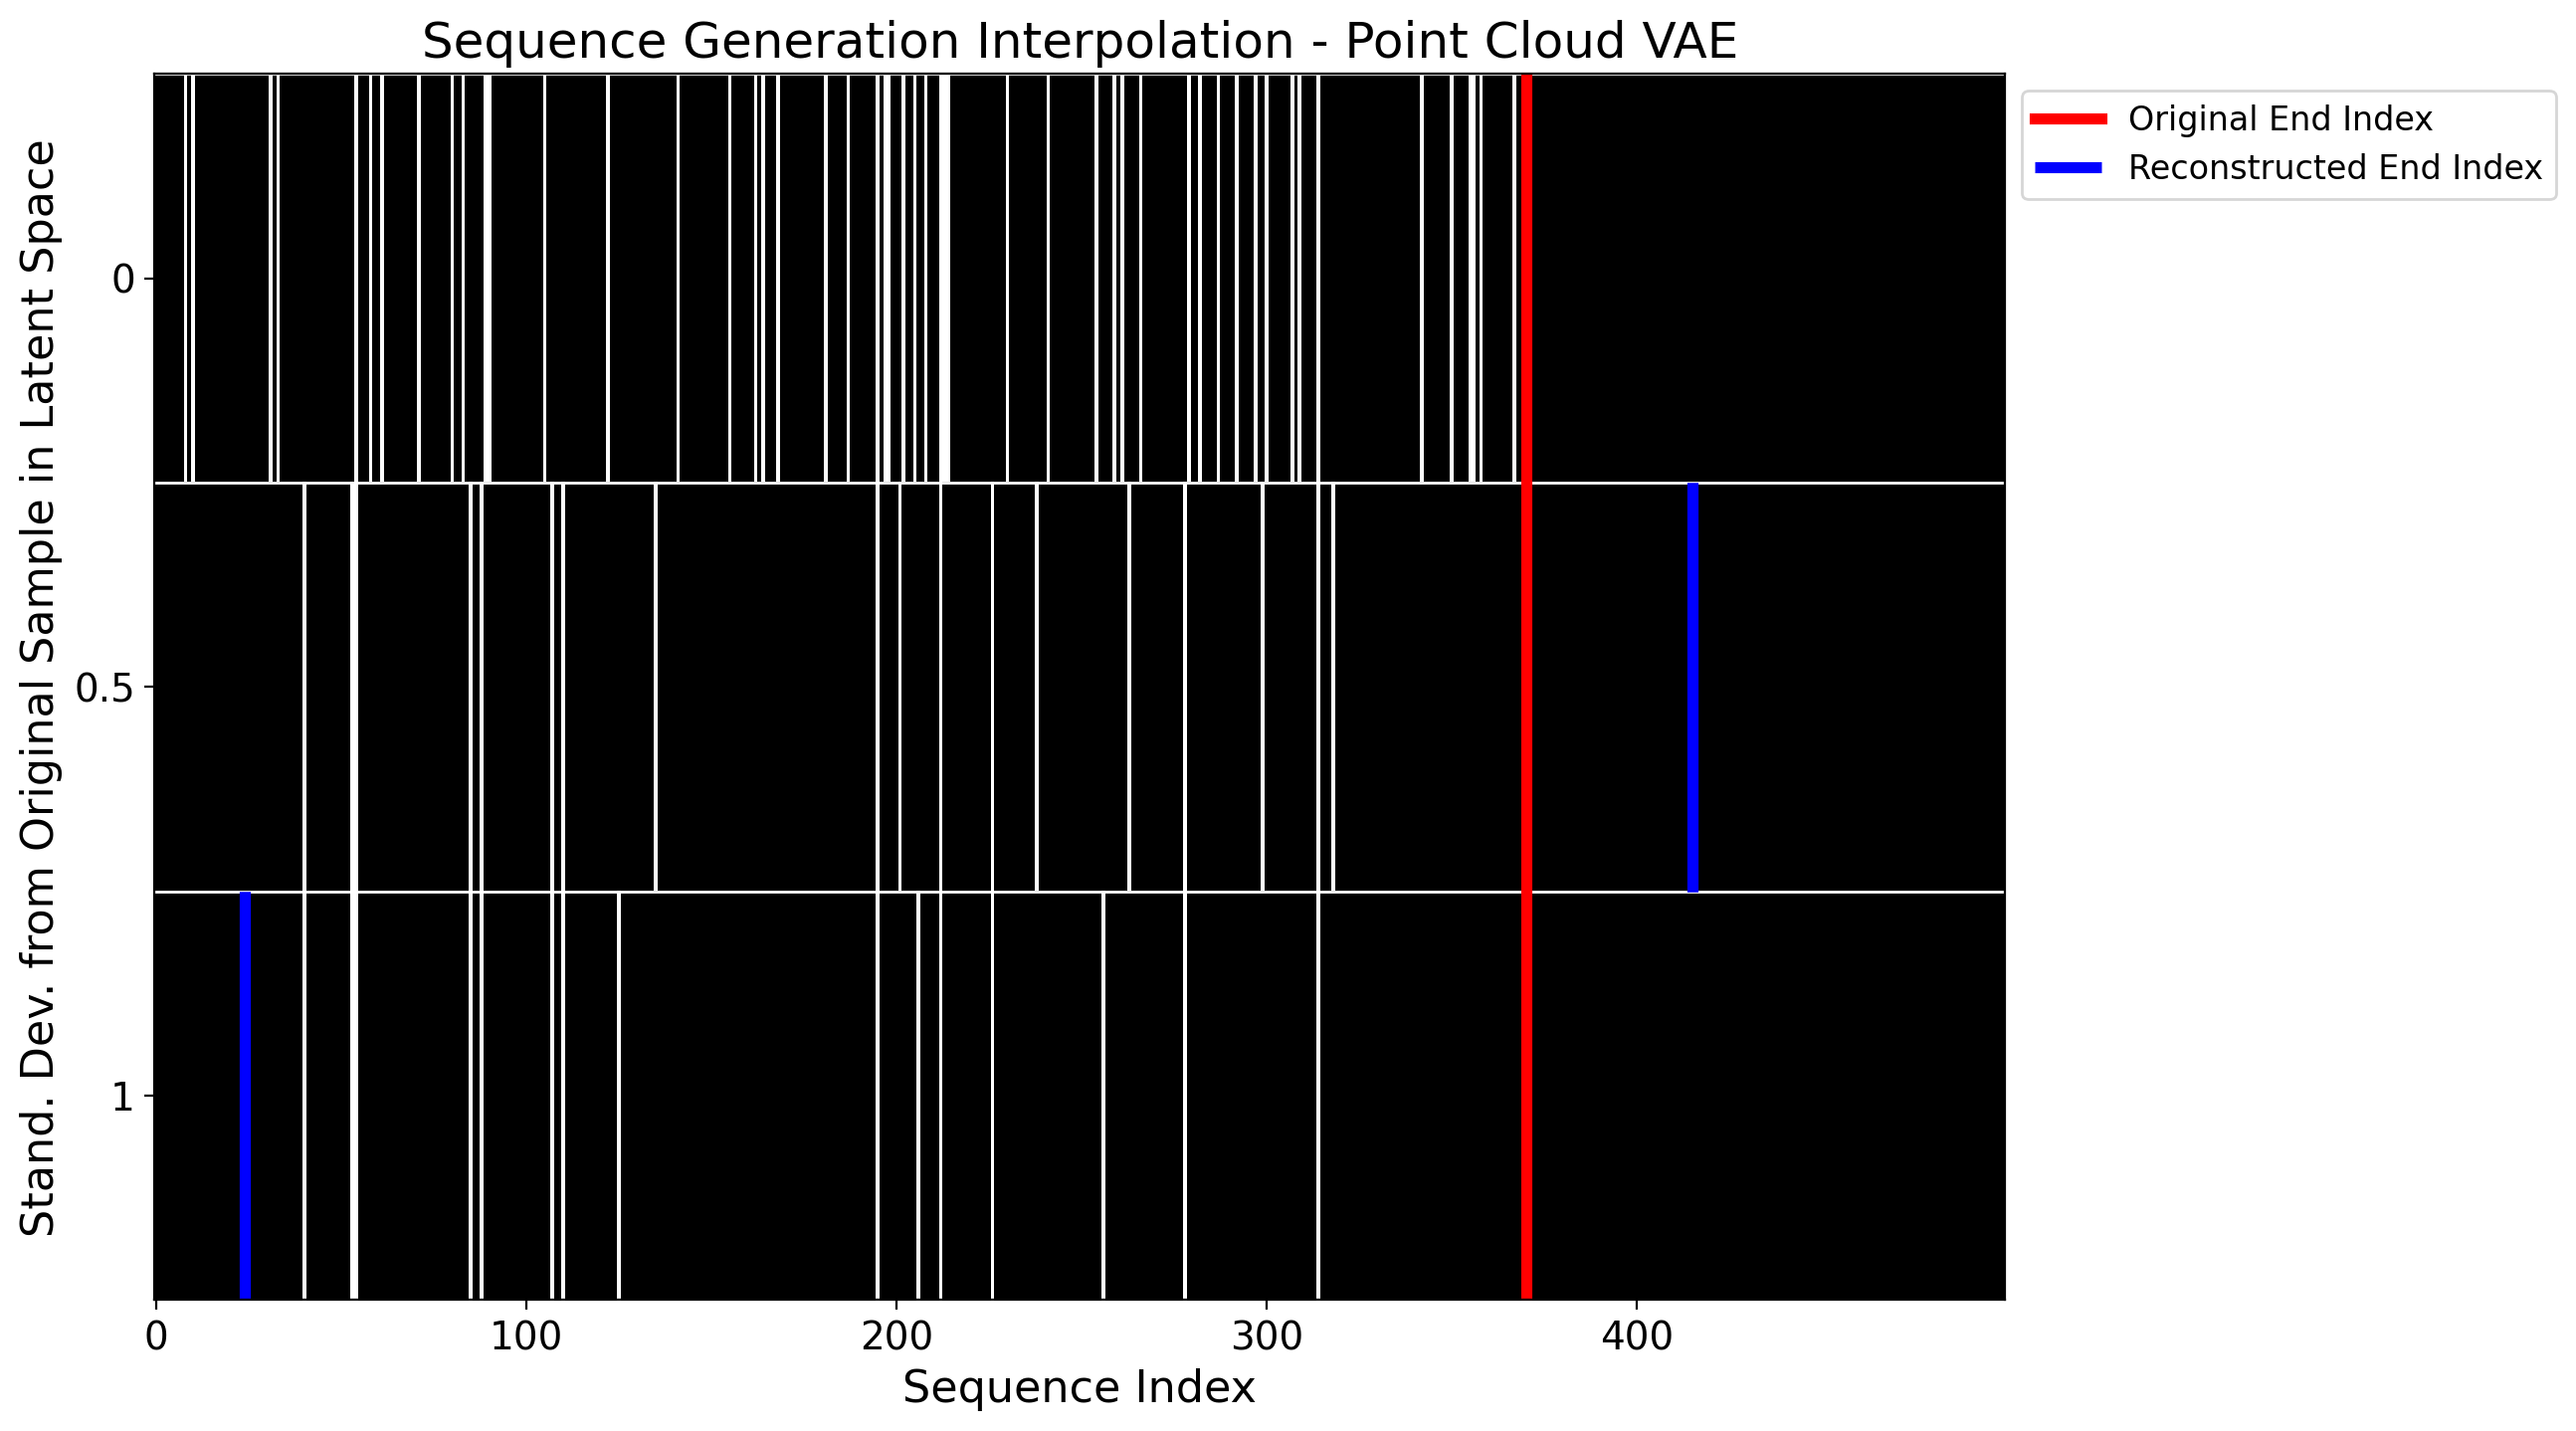

In [11]:
# Create a DataFrame with random values
# Generate random data
data = difference_vectors[1:,:500]  # 6x6 matrix

fig, ax = plt.subplots(figsize=(12, 8), dpi = 200)  # Adjust size here
# cmap = plt.cm.colors.ListedColormap(["red", "black"])
# Display heatmap
cax = ax.imshow(data, cmap='grey', aspect="auto")
# plt.colorbar(cax)

for i in range(data.shape[0]):
    ax.hlines(i - 0.5, -0.5, data.shape[1] - 0.5, color="white", linewidth=1)

yticks = [0, 0.5, 1]

for i in range(len(sequence_vectors)-1):

    if i == 0:
        ax.axvline(x=end_idx+1, color='red', linestyle='-', linewidth=4, label = 'Original End Index')
    else:
        prop_idx = torch.where(sequence_vectors[i] == 20)[0][0].item()
        if i == 1:
            ax.vlines([prop_idx, prop_idx], ymin = -0.5+i, ymax = (i)+0.5, color='b', linestyle='-', linewidth=4, label = 'Reconstructed End Index')
        else:
            ax.vlines([prop_idx, prop_idx], ymin = -0.5+i, ymax = (i)+0.5, color='b', linestyle='-', linewidth=4)

plt.yticks(range(data.shape[0]), yticks)
ax.tick_params(axis='both', labelsize=14) 
plt.ylabel('Stand. Dev. from Original Sample in Latent Space', fontsize = 16)
plt.title("Sequence Generation Interpolation - Point Cloud VAE", fontsize = 18)
plt.xlabel('Sequence Index', fontsize = 16)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

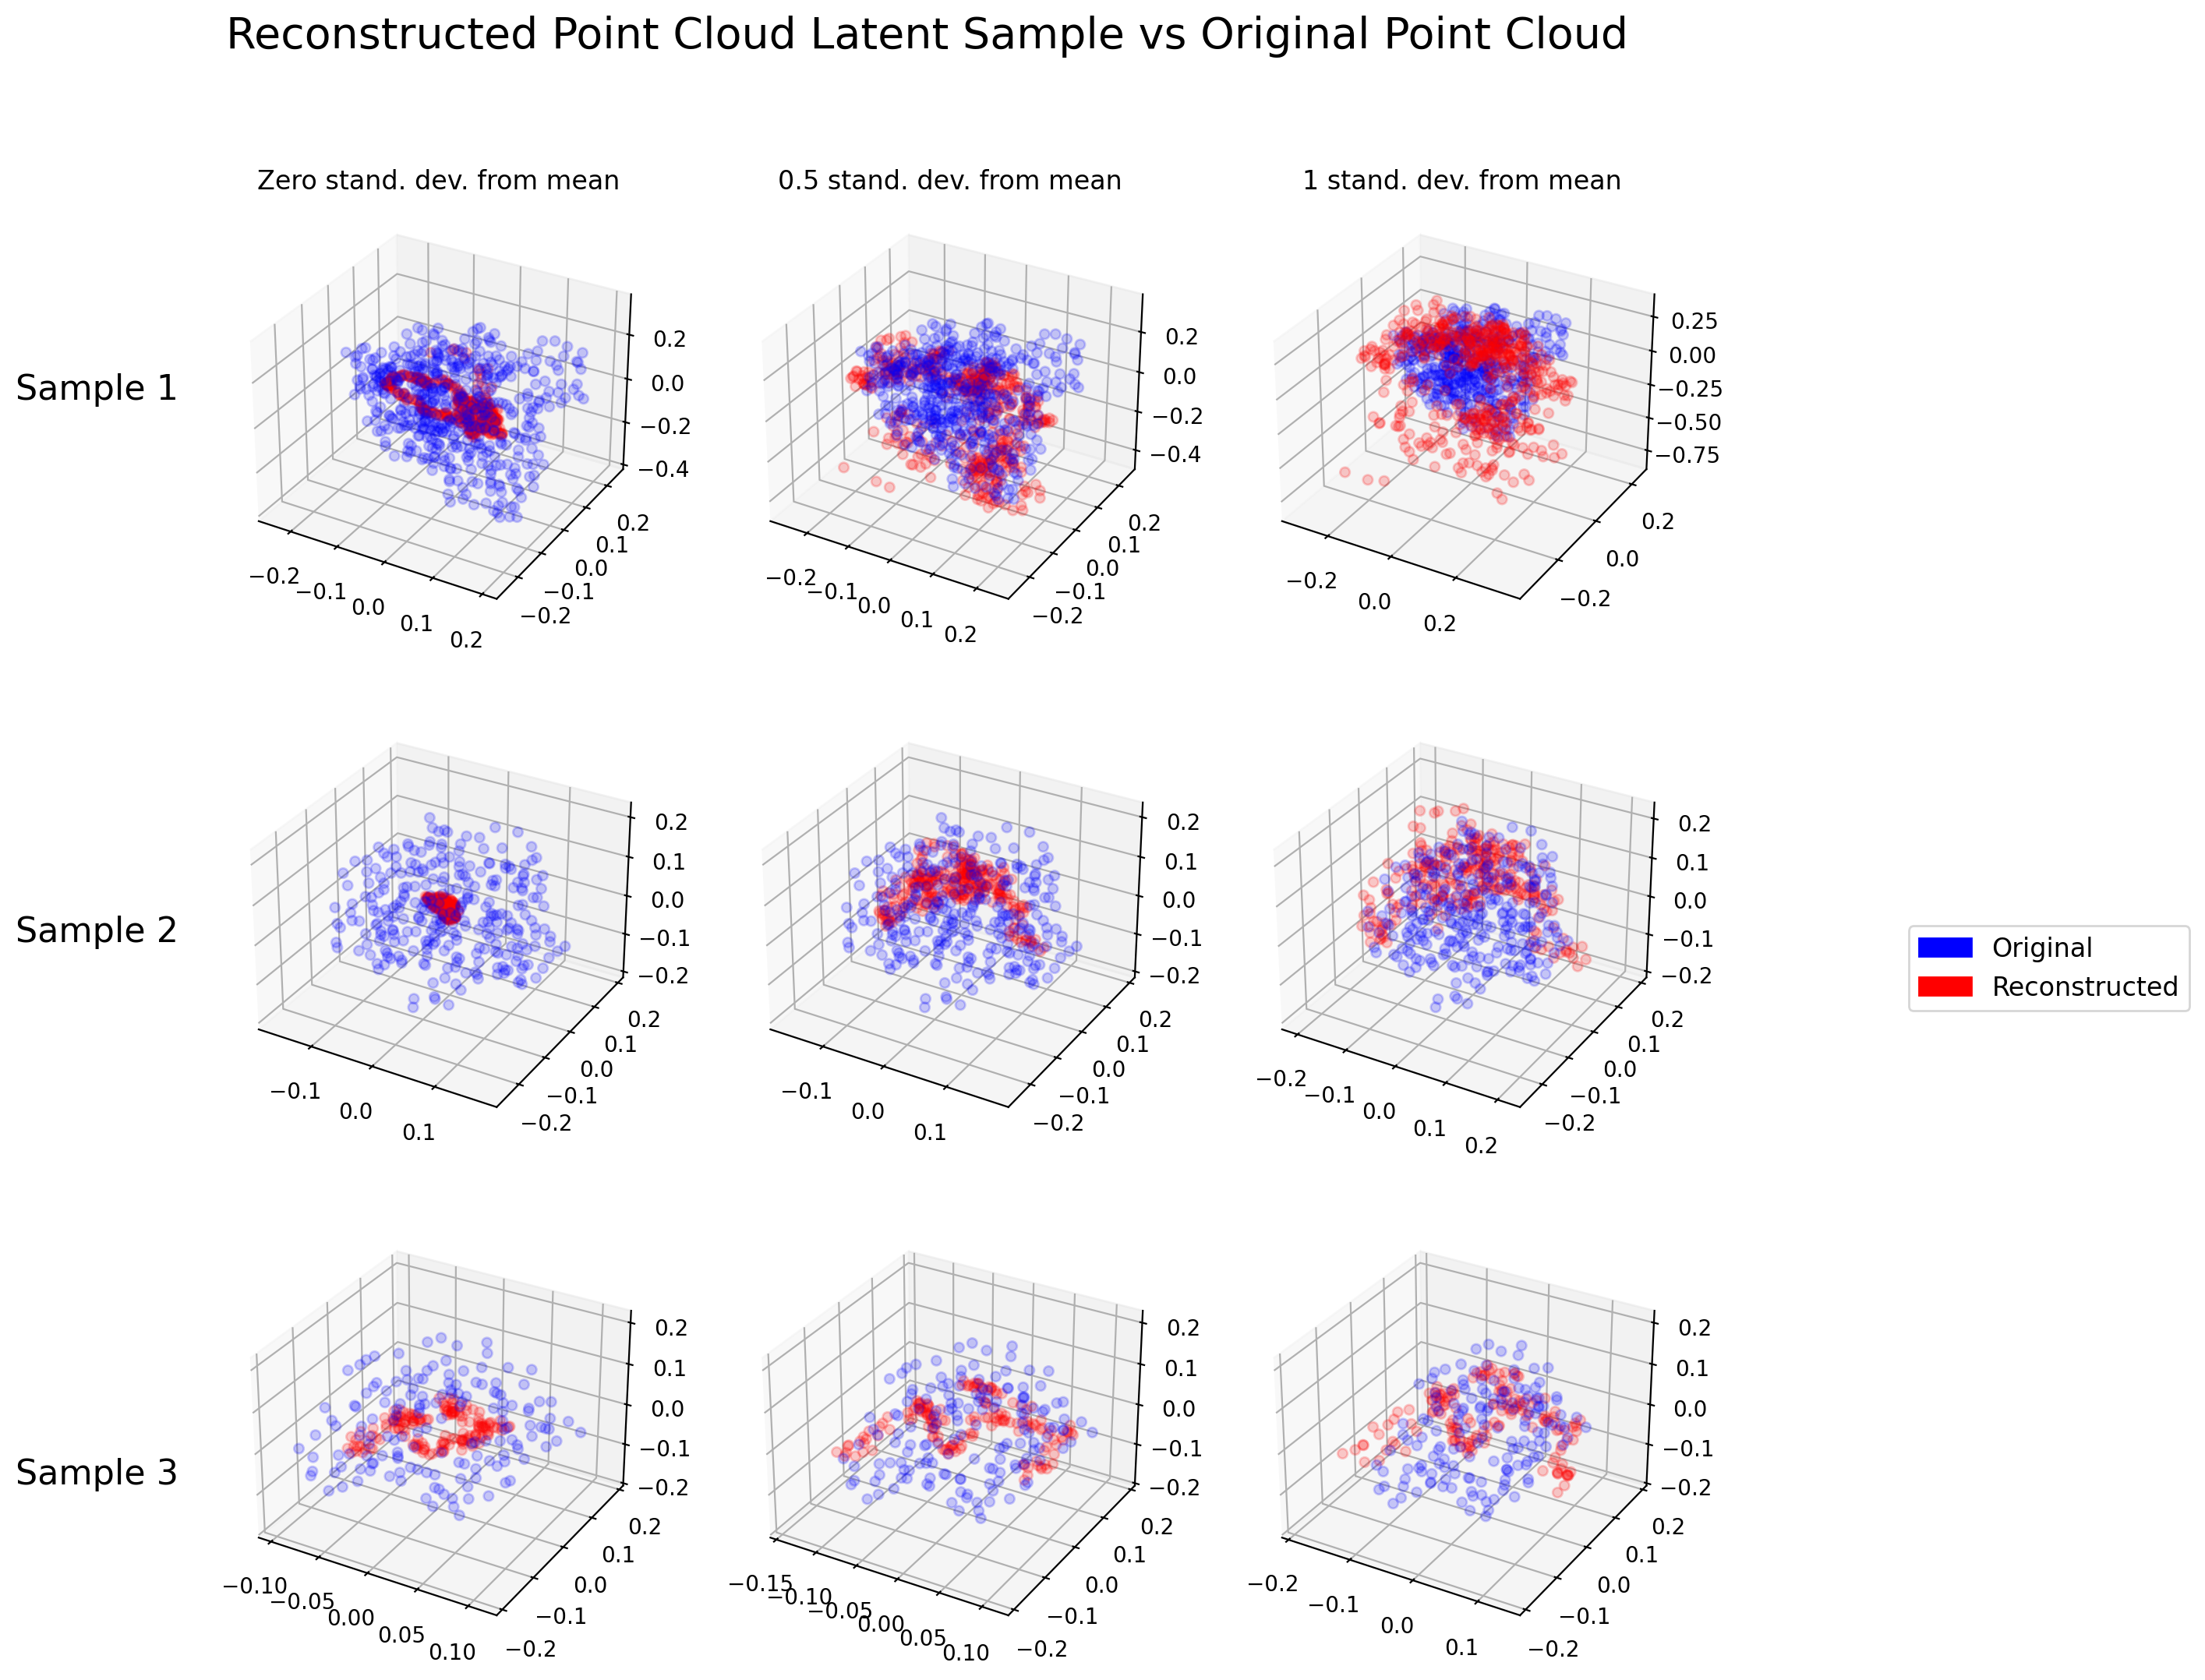

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

# Random data
sample_idx = 1
fig, axes = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(12, 12), dpi = 200)

start_idx = 60

for idx in range(start_idx,start_idx+3, 1):
    batch_idx = idx
    end_idx = torch.where(torch.sum(batch_sample[0][batch_idx, :,3:], dim = -1) != 0)[0][-1].item()

    # Create 3D plot
    # fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(12, 6))
    # ax = fig.add_subplot(111, projection='3d')

    for col in range(3):

        x = batch_sample[0][batch_idx, :end_idx,0]
        y = batch_sample[0][batch_idx, :end_idx,1]
        z = batch_sample[0][batch_idx, :end_idx,2]

        axes[idx - start_idx][col].scatter(x, y, z, c='b', alpha=0.2)

        reconstruction_batch = model_point_recontsructions[col]

        x = reconstruction_batch[batch_idx, :end_idx,0].detach().numpy()
        y = reconstruction_batch[batch_idx, :end_idx,1].detach().numpy()
        z = reconstruction_batch[batch_idx, :end_idx,2].detach().numpy()

        axes[idx - start_idx][col].scatter(x, y, z, c = 'r', alpha=0.2)

        # axes[idx - start_idx][col].set_title(f"Reconstructed Latent Sample Compared to Original ", fontsize=16)

# Add column labels at the top
col_labels = ['Zero stand. dev. from mean', '0.5 stand. dev. from mean', '1 stand. dev. from mean']
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, fontsize=12)

# Add row labels on the left

    
# plt.tight_layout()
fig.suptitle("Reconstructed Point Cloud Latent Sample vs Original Point Cloud", fontsize=20)

row_labels = ['Sample 1', 'Sample 2', 'Sample 3']
for i, label in enumerate(row_labels):
    # Adjust x (horizontal placement) and y (vertical placement) as needed
    fig.text(0.1, 0.78 - i * 0.29, label, va='center', ha='right', fontsize=16, rotation=0)

categories = {
    'Original': 'blue',
    'Reconstructed': 'red'
}

handles = [mpatches.Patch(color=color, label=label) for label, color in categories.items()]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.1, 0.5), fontsize=12)

    # Labels
    # ax.set_xlabel('X Axis')
    # ax.set_ylabel('Y Axis')
    # ax.set_zlabel('Z Axis')
    # plt.title('3D Scatter Plot')